# EEG Signal Processing:

### Author: Dr. Rahul Remanan (CEO and Chief Imagination Officer, [Moad Computer](https://www.moad.computer) )

This notebook cover the basics of EEG signal processing. 

The EEG data for this notebook is from the [Kaggle UPenn and Mayo Clinic's Seizure Detection Challenge](https://www.kaggle.com/c/seizure-detection).

## Part 01 -- [Implementing Filters in SciPy, Overview](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html):

The filter function is implemented as a direct II transposed structure. This means that the filter implements:

a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                      - a[1]*y[n-1] - ... - a[N]*y[n-N]

where M is the degree of the numerator, N is the degree of the denominator, and n is the sample number. It is implemented using the following difference equations (assuming M = N):

a[0]*y[n] = b[0] * x[n]               + d[0][n-1]

  d[0][n] = b[1] * x[n] - a[1] * y[n] + d[1][n-1]
  
  d[1][n] = b[2] * x[n] - a[2] * y[n] + d[2][n-1]
  
...

d[N-2][n] = b[N-1]*x[n] - a[N-1]*y[n] + d[N-1][n-1]

d[N-1][n] = b[N] * x[n] - a[N] * y[n]


where d are the state variables.

The rational transfer function describing this filter in the z-transform domain is:

                    -1              -M
        b[0] + b[1]z  + ... + b[M] z
$Y(z) = -------------------------------------------------------- X(z)

                    -1              -N
                    
        a[0] + a[1]z  + ... + a[N] z



### Noisy signal generator function:

In [3]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [4]:
t = np.linspace(-1, 1, 201)
x = (np.sin(2*np.pi*0.75*t*(1-t) + 2.1) +
     0.1*np.sin(2*np.pi*1.25*t + 1) +
     0.18*np.cos(2*np.pi*3.85*t))
xn = x + np.random.randn(len(t)) * 0.08

### Create an order 3 lowpass butterworth filter:

In [5]:
b, a = signal.butter(3, 0.05)

### Apply the filter to the noisy signal: 

Use lfilter_zi to choose the initial condition of the filter.

In [6]:
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0])

### Re-apply the filter: 

The result filtered at an order the same as filtfilt:

In [11]:
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

### Using filtfilt to create the filter:

In [12]:
y = signal.filtfilt(b, a, xn)

### Generate a comparison plot between the original signal and the various filtered versions:

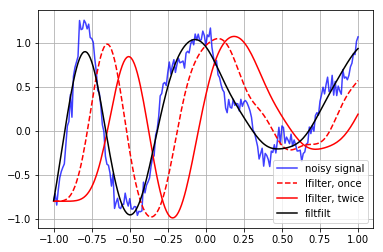

In [14]:
plt.figure
plt.plot(t, xn, 'b', alpha=0.75)
plt.plot(t, z, 'r--', t, z2, 'r', t, y, 'k')
plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
            'filtfilt'), loc='best')
plt.grid(True)
plt.show()

## Part 02 -- Butterworth Band-Pass Filter, Overview:

The Butterworth filter is a type of signal processing filter designed to have a frequency response as flat as possible in the passband. It is also referred to as a maximally flat magnitude filter.[1](https://en.wikipedia.org/wiki/Butterworth_filter) 

It was first described in 1930 by the British engineer and physicist Stephen Butterworth in his paper entitled "On the Theory of Filter Amplifiers".[2](https://github.com/rahulremanan/HIMA/blob/master/examples/Notebooks/05_Kaggle_seizure_detection/misc/journal_articles/Theory_of_filter_amplifiers--Butterworth.pdf) 

This implementation is described in detail in Stackoverflow.[3](https://stackoverflow.com/questions/21254472/multiple-plot-in-one-figure-in-python#21254745)

### Defining Butterworth band-pass filter function:

In [1]:
from scipy.signal import butter, lfilter

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [3]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Sample Application of using Butterworth band-pass filter:

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

### Set sample rate and desired cutoff frequencies (in Hz):

In [5]:
fs = 5000.0
lowcut = 500.0
highcut = 1250.0

### Plot the frequency response for a few different orders:

In [6]:
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

### Filter a noisy signal:

In [7]:
T = 0.05
nsamples = T * fs
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
f0 = 600.0
x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
x += a * np.cos(2 * np.pi * f0 * t + .11)
x += 0.03 * np.cos(2 * np.pi * 2000 * t)
plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


### Apply Butterworth filter on a synthetic time series function:

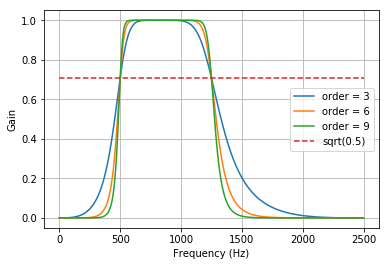

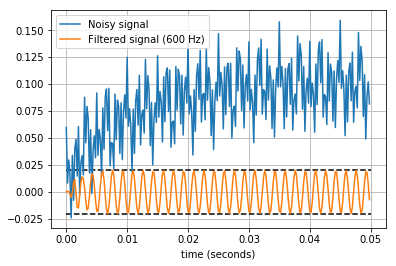

In [8]:
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

## Part 03 -- EEG Signal Processing:

### Set sample rate and desired cutoff frequencies (in Hz):

In [9]:
fs = 400.0
lowcut = 2.0
highcut = 100.0

### Read a random .mat file:

In [10]:
import scipy.io
mat = scipy.io.loadmat('../data/clips/Dog_1/Dog_1_ictal_segment_73.mat')

In [11]:
len(mat)

7

In [12]:
mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: unix, Software: R v3.0.2, Created on: Mon Apr  7 21:59:53 2014',
 '__version__': '1.0',
 'channels': array([[(array(['NVC0905_22_002_Ecog_c001'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c002'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c003'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c004'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c005'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c006'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c007'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c008'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c009'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c010'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c011'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c012'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c013'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c014'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c015'], dtype='<U24'), array(['NVC0905_22_002_Ecog_c016'], dtype='<U24'))]],
   

### Extract EEG data from the raw file:

In [13]:
eeg_data = mat['data']

In [14]:
len(eeg_data)

16

In [15]:
eeg_data

array([[-2.859000e+01, -2.959000e+01, -4.859000e+01, ...,  3.941000e+01,
         5.141000e+01,  6.541000e+01],
       [-3.650000e+00, -1.065000e+01, -8.650000e+00, ...,  1.193500e+02,
         1.203500e+02,  1.033500e+02],
       [-3.358500e+01, -2.458500e+01, -2.558500e+01, ...,  7.741500e+01,
         5.641500e+01,  2.841500e+01],
       ...,
       [ 3.665250e+01,  3.765250e+01,  4.765250e+01, ..., -1.453475e+02,
        -1.253475e+02, -1.013475e+02],
       [ 7.000000e-01,  3.700000e+00,  6.700000e+00, ..., -6.130000e+01,
        -4.230000e+01, -2.030000e+01],
       [-1.750000e-02,  5.982500e+00,  1.298250e+01, ..., -1.040175e+02,
        -7.301750e+01, -6.001750e+01]])

In [16]:
eeg_data.shape

(16, 400)

### Channel wise plot of the EEG signals:

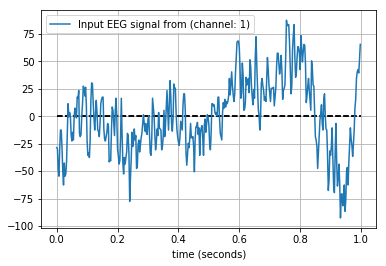

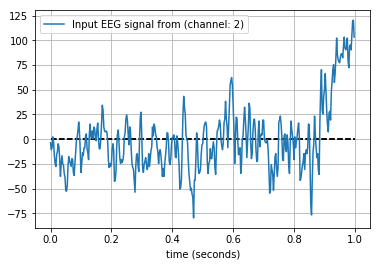

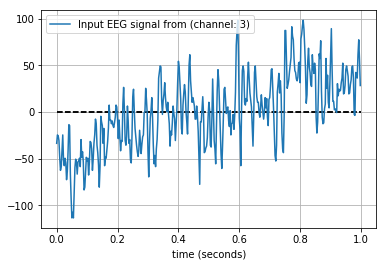

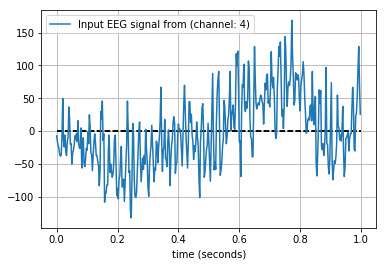

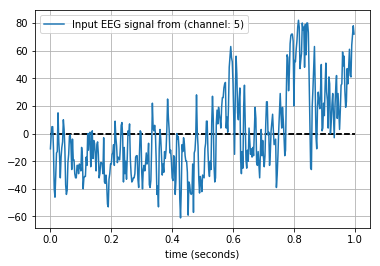

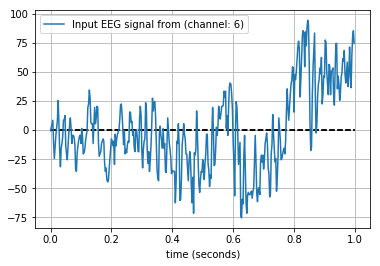

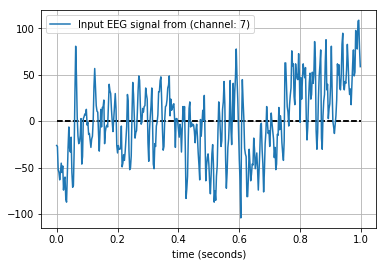

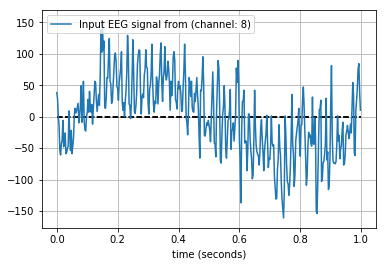

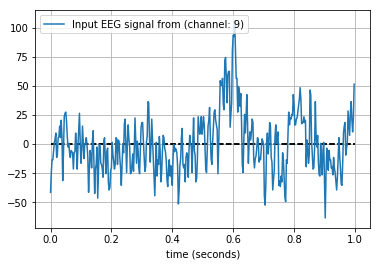

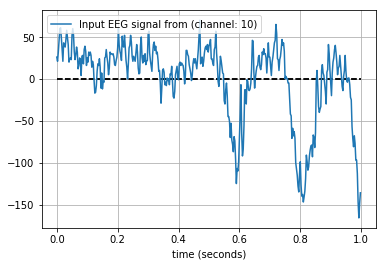

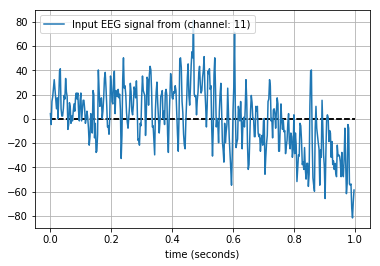

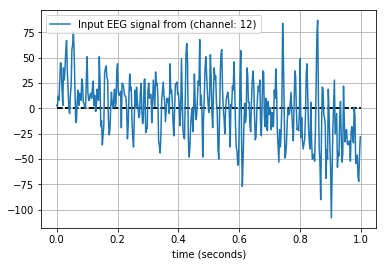

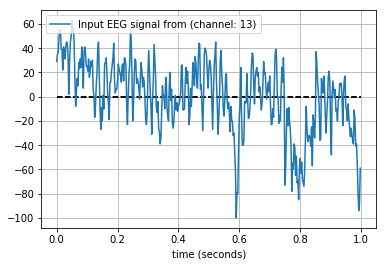

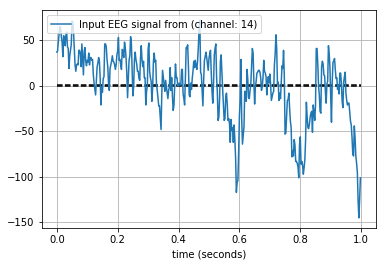

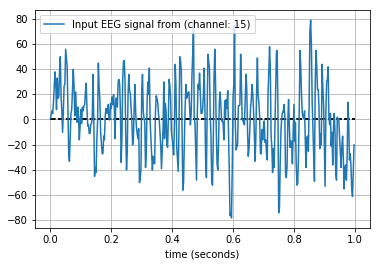

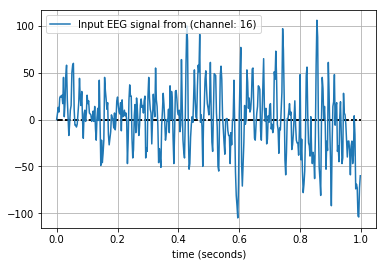

In [17]:
for n in range(eeg_data.shape[0]):
    T = 1
    nsamples = eeg_data.shape[1]
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    plt.figure(2)
    plt.clf()
    plt.plot(t, eeg_data[n], label='Input EEG signal from (channel: %g)' % (n+1))
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')
    plt.show()

## Part 04 --  Combining Butterworth Band-pass Filter and EEG:

### Resample the data:

In [18]:
eeg_data_resampled = scipy.signal.resample(eeg_data, int(fs), axis=1)

### Plot the frequency response for a few different orders:

In [19]:
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

### Select a random channel:

In [20]:
from random import randint
rnd_ch = randint(0, len(eeg_data)-1)
print ("Applying Butterworth bandpass filter on EEG signals from channel: " + str(rnd_ch))

Applying Butterworth bandpass filter on EEG signals from channel: 9


### Filter a noisy signal:

In [21]:
T = 1
nsamples = fs
t = np.linspace(0, T, nsamples, endpoint=False)
a = 0.02
plt.figure(2)
plt.clf()
plt.plot(t, eeg_data_resampled[rnd_ch], label='Resampled EEG signal from (channel: %g)' % rnd_ch)

/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


### Apply Butterworth Band-pass filter on a random EEG signal channel:

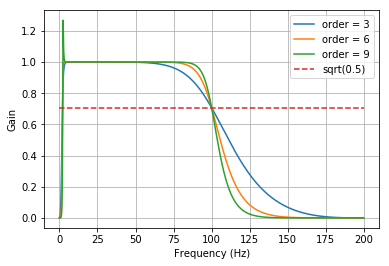

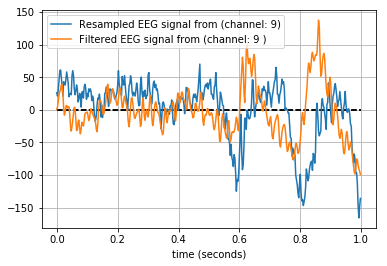

In [22]:
y = butter_bandpass_filter(eeg_data_resampled[rnd_ch], lowcut, highcut, fs, order=6)
plt.plot(t, y, label='Filtered EEG signal from (channel: %g )' % rnd_ch)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()